# INF581 Lab6: Deep Reinforcement Learning

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf581-2024-students/main/logo.jpg" style="float: left; width: 15%" />

[INF581-2024](https://moodle.polytechnique.fr/course/view.php?id=17108) Lab session #5

2019-2024 Jérémie Decock

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeremiedecock/polytechnique-inf581-2024-students/blob/main/lab6_rl3_deep_reinforcement_learning.ipynb)

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf581-2024-students/main?filepath=lab6_rl3_deep_reinforcement_learning.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/main/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/jeremiedecock/polytechnique-inf581-2024-students/blob/main/lab6_rl3_deep_reinforcement_learning.ipynb)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://github.com/jeremiedecock/polytechnique-inf581-2024-students/raw/main/lab6_rl3_deep_reinforcement_learning.ipynb)

## Introduction

In the previous lab, we dealt with reinforcement learning in discrete state and action spaces.
To do so, we used methods based on action-value function and especially $Q$-function estimation.
The $Q$-function was stored in a table and updated with on- or off- policy algorithms (namely SARSA and $Q$-Learning).

Yet, these methods do not scale to large state spaces and especially not to the case of continuous state spaces.
To address these issues one can either extend the value-based methods making use of the value-function approximation or directly search in policy spaces.
In this lab, we will explore both solutions.

The first part of this lab presents the problem to solve: the CartPole environment.

In the second part, we will apply value-function approximation methods (namely DQN) to solve the CartPole problem.

In the third part of this lab, we will search in a family of parameterized policies $\pi_\theta(s, a)$ using a policy gradient method.

As for previous labs, you can either:
- open, edit and execute the notebook in *Google Colab* following this link: https://colab.research.google.com/github/jeremiedecock/polytechnique-inf581-2024-students/blob/main/lab6_rl3_deep_reinforcement_learning.ipynb ; this is the **recommended** choice as you have nothing to install on your computer
- open, edit and execute the notebook in *MyBinder* (if for any reason the Google Colab solution doesn't work): https://mybinder.org/v2/gh/jeremiedecock/polytechnique-inf581-2024-students/main?filepath=lab6_rl3_deep_reinforcement_learning.ipynb
- download, edit and execute the notebook on your computer if Python3 and JypyterLab are already installed: https://github.com/jeremiedecock/polytechnique-inf581-2024-students/raw/main/lab6_rl3_deep_reinforcement_learning.ipynb

If you work with Google Colab or MyBinder, **remember to save or download your work regularly or you may lose it!**

## Name your work

Replace the values in the following dictionary `info`. Your Email must match your class email address. Your Alias will be shown on the public leaderboard (to identify yourself).

In [67]:
info = {
        'Email' : 'mohamed-aymen.bouyahia@ensta-paris.fr',
        'Alias' : 'Aymen', # (change this in case you want to identify yourself on the leaderboard)
}

## Setup the Python environment

This notebook relies on several libraries including `torch`, `gymnasium`, `numpy`, `pandas`, `seaborn`, `imageio`, `pygame`, and `tqdm`.
A complete list of dependencies can be found in the provided [requirements-lab6.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf581-2024-students/master/requirements-lab6.txt) file.

### If you use Google Colab

Execute the next cell to install required libraries.

In [68]:
import sys, subprocess

def is_colab():
    return "google.colab" in sys.modules

def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())

if is_colab():
    run_subprocess_command("apt install xvfb x11-utils")
    run_subprocess_command("pip install gymnasium pyvirtualdisplay")

Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+5build2).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [69]:
#! apt install xvfb x11-utils && pip install gymnasium pyvirtualdisplay

### If you have downloaded the notebook on your computer and execute it in your own Python environment

To set up the necessary dependencies, first download the [requirements-lab6.txt](https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf581-2024-students/master/requirements-lab6.txt) file and ensure it is located in the same directory as this notebook. Next, run the following command to establish a [Python virtual environment (venv)](https://docs.python.org/3/library/venv.html) that includes all the essential libraries for this lab.

#### On Posix systems (Linux, MacOSX, WSL, ...)

```bash
python3 -m venv env-lab6
source env-lab6/bin/activate
python3 -m pip install --upgrade pip
python3 -m pip install -r requirements-lab6.txt
```

#### On Windows

```bash
python3 -m venv env-lab6
env\Scripts\activate.bat
python3 -m pip install --upgrade pip
python3 -m pip install -r requirements-lab6.txt
```

### Run INF581 notebooks locally in a dedicated Docker container

If you are familiar with Docker, an image is available on Docker Hub for this lab:

```bash
docker run -it --rm -p 8888:8888 -v "${PWD}":/home/jovyan/work jdhp/inf581-lab6:latest
```

If you encounter an error during the notebook's execution indicating that writing a file is not possible, this issue may stem from the user ID within the container lacking the necessary permissions in the project directory. This problem can be resolved by modifying the directory's permissions, for example, using the command:

```bash
chmod 777 .
rm lab6_*.gif
rm *.pth
rm lab6_reinforce_cartpole_trains_result.png
rm lab6_reinforce_cartpole_trains_result_agg.png
```

### Import required packages

In [70]:
import collections
import gymnasium as gym
import itertools
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import random
import time
import torch
from torch.optim.lr_scheduler import _LRScheduler
from typing import List, Tuple, Deque, Optional, Callable
# from inf581 import *

In [71]:
%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm

In [72]:
gym.__version__

'0.29.1'

In [73]:
sns.set_context("talk")

### Create a Gymnasium rendering wrapper to visualize environments as GIF images within the notebook

In [74]:
# To display GIF images in the notebook

import imageio     # To render episodes in GIF images (otherwise there would be no render on Google Colab)
                   # C.f. https://stable-baselines.readthedocs.io/en/master/guide/examples.html#bonus-make-a-gif-of-a-trained-agent
import IPython
from IPython.display import Image

if is_colab():
    import pyvirtualdisplay

    _display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                        size=(1400, 900))
    _ = _display.start()

class RenderWrapper:
    def __init__(self, env, force_gif=False):
        self.env = env
        self.force_gif = force_gif
        self.reset()

    def reset(self):
        self.images = []

    def render(self):
        if not is_colab():
            self.env.render()
            time.sleep(1./60.)

        if is_colab() or self.force_gif:
            img = self.env.render()         # Assumes env.render_mode == 'rgb_array'
            self.images.append(img)

    def make_gif(self, filename="render"):
        if is_colab() or self.force_gif:
            imageio.mimsave(filename + '.gif', [np.array(img) for i, img in enumerate(self.images) if i%2 == 0], fps=29, loop=0)
            return Image(open(filename + '.gif','rb').read())

    @classmethod
    def register(cls, env, force_gif=False):
        env.render_wrapper = cls(env, force_gif=True)

## Define some parameters

In [75]:
start_time = time.time()

### Number of trainings

To achieve more representative outcomes at the conclusion of each exercise, we average the results across multiple training sessions. The `NUMBER_OF_TRAININGS` variable specifies the number of training sessions conducted before the results are displayed.

We recommend setting a lower value (such as 1 or 2) during the development and testing phases of your implementations. Once you have completed your work and are confident in its functionality, you can increase the number of training sessions to minimize the variance in results. Be aware that a higher number of training sessions will extend the execution time, so adjust this setting in accordance with your computer's capabilities.

Additionally, you have the option to assign a specific value to the `NUMBER_OF_TRAININGS` variable for each exercise directly within the cells where the training loop is defined (the `NUMBER_OF_TRAININGS` variable is commented out at the beginning of these cells).

In [76]:
NUMBER_OF_TRAININGS = 1

### PyTorch device

Retain the cell below to ask PyTorch to utilize the GPU if it's available. For utilizing a GPU on Google Colab, you also have to activate it following the steps outlined [here](https://colab.research.google.com/notebooks/gpu.ipynb).

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set the device to CUDA if available, otherwise use CPU

Alternatively, you can uncomment the next cell to explicitly instruct PyTorch to train neural networks using the CPU.

In [78]:
#device = "cpu"

In [79]:
print(f"PyTorch will train neural networks on {device}")

PyTorch will train neural networks on cpu


## Part 1: Hands on Cart Pole environment

As for previous labs, we will use standard environments provided by the Gymnasium, but this time, we will try to solve the CartPole-v1 environment (c.f. https://gymnasium.farama.org/environments/classic_control/cart_pole/) which offers a continuous state space and discrete action space.
The Cart Pole task consists in maintaining a pole in a vertical position by moving a cart on which the pole is attached with a joint.
No friction is considered.
The task is supposed to be solved if the pole stays up-right (within 15 degrees) for 200 steps in average over 100 episodes while keeping the cart position within reasonable bounds.
The state is given by $\{x,\frac{\partial x}{\partial t},\omega,\frac{\partial \omega}{\partial t}\}$ where $x$ is the position of the cart and $\omega$ is the angle between the pole and vertical position.
There are only two possible actions: $a \in \{0, 1\}$ where $a = 0$ means "push the cart to the LEFT" and $a = 1$ means "push the cart to the RIGHT".

### Exercise 1: Hands on Cart Pole

**Task 1.1:** refer to the following link [CartPole Environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to familiarize yourself with the CartPole environment.

**Note:** for a refresher on the key concepts of Gymnasium, you can visit this [Basic Usage Guide](https://gymnasium.farama.org/content/basic_usage/).

In [80]:
#Documentation!

Print some information about the environment:

In [81]:
env = gym.make('CartPole-v1')

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n.item()

print(f"State space size is: { state_dim }")
print(f"State upper bounds: { env.observation_space.high }")
print(f"State lower bounds: { env.observation_space.high }")
print(f"Action space size is: { action_dim }")
print("Actions are: {" + ", ".join([str(a) for a in range(env.action_space.n)]) + "}")
env.close()

State space size is: 4
State upper bounds: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
State lower bounds: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Action space size is: 2
Actions are: {0, 1}


**Task 1.2:** Run the following cells and check different basic
policies (for instance constant actions or randomly drawn actions) to discover the CartPole environment.
Although this environment has easy dynamics that can be computed analytically, we will solve this problem with deep Reinforcement Learning methods.

#### Test the CartPole environment with a constant policy

In [82]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

[ 0.03804076 -0.03773942 -0.01898679  0.04890104]
[ 0.03728597  0.15764956 -0.01800877 -0.2497114 ]
[ 0.04043896  0.353024   -0.023003   -0.5480198 ]
[ 0.04749944  0.15823263 -0.0339634  -0.26267236]
[ 0.05066409  0.3538225  -0.03921684 -0.5658713 ]
[ 0.05774054  0.15927204 -0.05053427 -0.28579676]
[ 0.06092598 -0.03509415 -0.0562502  -0.00947042]
[ 0.0602241  -0.22936617 -0.05643961  0.26494786]
[ 0.05563677 -0.42363903 -0.05114065  0.5393087 ]
[ 0.047164   -0.61800617 -0.04035448  0.8154495 ]
[ 0.03480387 -0.812553   -0.02404549  1.0951711 ]
[ 0.01855281 -1.0073501  -0.00214207  1.3802137 ]
[-1.5941918e-03 -1.2024453e+00  2.5462205e-02  1.6722260e+00]
[-0.0256431  -1.0076281   0.05890673  1.38758   ]
[-0.04579566 -0.81328773  0.08665833  1.1138836 ]
[-0.06206141 -0.6194039   0.108936    0.84959483]
[-0.07444949 -0.81582934  0.1259279   1.1744504 ]
[-0.09076608 -0.62254846  0.14941691  0.9237498 ]
[-0.10321705 -0.4297263   0.1678919   0.6815045 ]
[-0.11181158 -0.23728466  0.18152198  

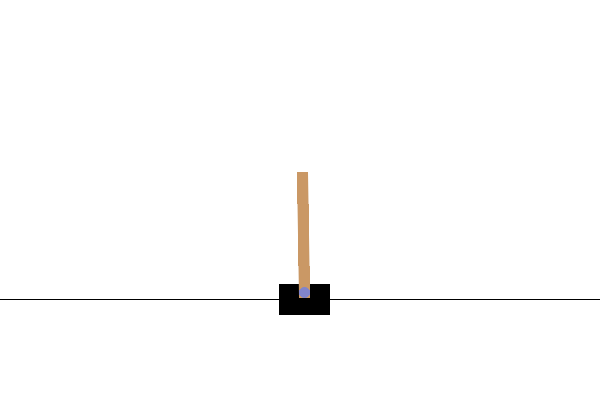

In [83]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

observation, info = env.reset()
done = False

for t in range(50):
    env.render_wrapper.render()

    if not done:
        print(observation)
    else:
        print("x", end="")

    # TODO...
    action = env.action_space.sample()

    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated


print()
env.close()

env.render_wrapper.make_gif("lab6_cartpole_left")

[ 0.03170561 -0.0315908  -0.04626345 -0.03135388]
[ 0.03107379  0.16416301 -0.04689053 -0.33826703]
[ 0.03435705 -0.03026142 -0.05365587 -0.06073169]
[ 0.03375182 -0.22457464 -0.0548705   0.21455142]
[ 0.02926033 -0.02871292 -0.05057947 -0.09492284]
[ 0.02868607 -0.22307481 -0.05247793  0.18138313]
[ 0.02422458 -0.4174081  -0.04885026  0.45706034]
[ 0.01587641 -0.22163078 -0.03970906  0.14938842]
[ 0.0114438  -0.02596337 -0.03672129 -0.15555273]
[ 0.01092453 -0.22054084 -0.03983235  0.12532307]
[ 0.00651371 -0.41507018 -0.03732589  0.405178  ]
[-0.00178769 -0.60964346 -0.02922232  0.68586344]
[-0.01398056 -0.41412827 -0.01550505  0.3841257 ]
[-0.02226312 -0.60902673 -0.00782254  0.6718799 ]
[-0.03444366 -0.4137969   0.00561506  0.37674433]
[-0.0427196  -0.21875514  0.01314994  0.08583714]
[-0.0470947  -0.02382413  0.01486669 -0.20266813]
[-0.04757118  0.17108208  0.01081332 -0.4906245 ]
[-0.04414954  0.36604983  0.00100083 -0.77988   ]
[-0.03682854  0.17091414 -0.01459677 -0.48688233]


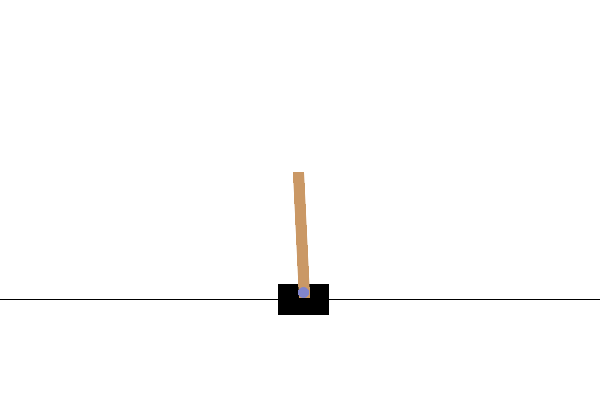

In [84]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

observation, info = env.reset()
done = False

for t in range(50):
    env.render_wrapper.render()

    if not done:
        print(observation)
    else:
        print("x", end="")

    # TODO...
    action = env.action_space.sample()

    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

print()
env.close()

env.render_wrapper.make_gif("lab6_cartpole_right")

#### Test the CartPole environment with a random policy

[-0.00253079 -0.00483005  0.00215211 -0.02850538]
[-0.00262739 -0.1999828   0.00158201  0.26485577]
[-0.00662704 -0.00488347  0.00687912 -0.02732774]
[-0.00672471  0.19013916  0.00633257 -0.31783232]
[-2.9219289e-03  3.8517034e-01 -2.4078108e-05 -6.0851145e-01]
[ 0.00478148  0.58029264 -0.01219431 -0.90120196]
[ 0.01638733  0.77557766 -0.03021835 -1.1976928 ]
[ 0.03189889  0.9710774  -0.0541722  -1.4996914 ]
[ 0.05132043  1.166814   -0.08416603 -1.8087842 ]
[ 0.07465671  1.3627676  -0.12034172 -2.12639   ]
[ 0.10191206  1.1690296  -0.16286951 -1.8731799 ]
[ 0.12529266  1.3655132  -0.2003331  -2.211677  ]
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
[ 0.0173744  -0.03563331  0.04015381 -0.03119507]
[ 0.01666174  0.1588905   0.0395299  -0.31094354]
[ 0.01983955 -0.0367717   0.03331103 -0.00606076]
[ 0.01910411  0.15785709  0.03318982 -0.28805035]
[ 0.02226125  0.3524904   0.02742881 -0.5700835 ]
[ 0.02931106  0.15699473  0.01602714 -0.26888725]
[ 0.03245096 -0.03835223  0.0

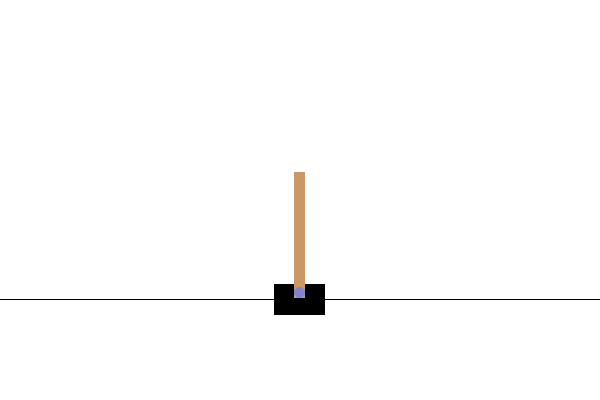

In [85]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

for episode_index in range(5):
    observation, info = env.reset()
    done = False

    for t in range(70):
        env.render_wrapper.render()

        if not done:
            print(observation)
        else:
            print("x", end="")

        # TODO...
        action = env.action_space.sample()

        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    print()
    env.close()

env.render_wrapper.make_gif("lab6_cartpole_random")

## Part 2: Deep value-based reinforcement learning with Deep Q-Networks (DQN)

In this part, we will begin our exploration of deep reinforcement learning with Deep Q-Networks (DQN), a famous value-based method.

Deep reinforcement learning methods like DQN (Deep Q-Networks) are significant advancements over tabular methods such as Q-Learning because they can handle complex, high-dimensional environments that were previously intractable. While Q-Learning is limited to environments where the state and action spaces are sufficiently small to maintain a table of values, DQN uses neural networks to approximate the Q-value function, allowing it to generalize across similar states and scale to problems with vast state spaces. This enables DQN to learn optimal policies for tasks like video games, robotic control, and other applications where the number of possible states is extraordinarily large.

While DQN was designed to tackle large environments like Atari games, the primary focus of this lab is to delve into the underlying algorithms, understand them thoroughly, and evaluate them comprehensively. It's important to note that working with not-so-deep networks captures the essence of deep reinforcement learning, excluding the computational expense. The transition from tabular Q-learning to DQN involves significant implications, primarily due to the ability of DQN to handle high-dimensional state spaces. Moving from DQN to very-deep-DQN is primarily a matter of scale and computational resources. The core principles remain the same, and understanding these principles is the key to mastering reinforcement learning, regardless of the complexity of the network used.
For these reasons, in this lab, we will focus on studying the CartPole environment. The CartPole problem is a classic in reinforcement learning, and it provides a simpler and more manageable context for understanding the principles of DQN. The convergence in the CartPole environment is much faster than in Atari games - typically within a minute, as opposed to approximately 10 hours on a well-equipped personal computer for Atari games. This allows us to experiment and iterate more quickly, facilitating a deeper understanding of the algorithms at play.

### Exercise 2: Implement a naive value-based deep reinforcement learning algorithm

Our first step will be to write a naive implementation of a version of Q-Learning, where the Q-function is approximated by a neural network. This approach combines traditional Q-Learning with the power of function approximation provided by neural networks, allowing us to handle environments with large state spaces.

#### The algorithm

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\gamma$<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\mathbf{s} \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $\mathbf{a} \leftarrow \epsilon\text{-greedy}(\mathbf{s}, \hat{Q}_{\mathbf{\omega}}$ $)$<br>
		$\quad\quad$ $r, \mathbf{s'} \leftarrow \text{env.step}(\mathbf{a})$<br>
		$\quad\quad$ $\mathbf{\omega} \leftarrow \mathbf{\omega} + \alpha \left[ r + \gamma \max_{\mathbf{a}^\star \in \mathcal{A}}\hat{Q}_{\mathbf{\omega}}(\mathbf{s'})_{\mathbf{a}^\star} - \hat{Q}_{\mathbf{\omega}}(\mathbf{s})_{\mathbf{a}} \right] ~ \nabla_{\mathbf{\omega}} \hat{Q}_{\mathbf{\omega}}(\mathbf{s})_{\mathbf{a}}$ <br>
		$\quad\quad$ $\mathbf{s} \leftarrow \mathbf{s'}$ <br>
	$\quad$ <b>UNTIL</b> $\mathbf{s}$ is final<br><br>
<b>RETURN</b> $\mathbf{\omega}$ <br>

#### PyTorch Refresher and Cheat Sheet

In this lab, we will be implementing our deep reinforcement learning algorithms using PyTorch.
If you need a refresher, you might find this [PyTorch Cheat Sheet](https://pytorch.org/tutorials/beginner/ptcheat.html) helpful. It provides a quick reference for many of the most commonly used PyTorch functions and concepts, and can be a valuable resource as you work through this lab.

#### Implement the Q-network

The Q-Network is used to approximate the action value function, which gives the expected future reward for taking a particular action in a particular state. The network is trained to minimize the difference between its predicted Q-values and the actual return received.

**Task 2.1:** implement the constructor and the `forward` method of the Q-network we will use in our RL agents

In [86]:
class QNetwork(torch.nn.Module):
    """
    A Q-Network implemented with PyTorch.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        First fully connected layer.
    layer2 : torch.nn.Linear
        Second fully connected layer.
    layer3 : torch.nn.Linear
        Third fully connected layer.

    Methods
    -------
    forward(x: torch.Tensor) -> torch.Tensor
        Define the forward pass of the QNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int, nn_l1: int, nn_l2: int):
        """
        Initialize a new instance of QNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        nn_l1 : int
            The number of neurons on the first layer.
        nn_l2 : int
            The number of neurons on the second layer.
        """
        super(QNetwork, self).__init__()

        # TODO...
        self.layer1 = torch.nn.Linear(n_observations, nn_l1)
        self.layer2 = torch.nn.Linear(nn_l1, nn_l2)
        self.layer3 = torch.nn.Linear(nn_l2, n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Define the forward pass of the QNetwork.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor (state).

        Returns
        -------
        torch.Tensor
            The output tensor (Q-values).
        """

        # TODO...
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        x = self.layer3(x)

        return x

#### Implement an inference function

**Task 2.2:** Your next assignment is to complete the function below, which will be used to evaluate the performance of an agent in a simulated environment over one or multiple episodes.

In [87]:
def test_q_network_agent(env: gym.Env, q_network: torch.nn.Module, num_episode: int = 1, render: bool = True) -> List[int]:
    """
    Test a naive agent in the given environment using the provided Q-network.

    Parameters
    ----------
    env : gym.Env
        The environment in which to test the agent.
    q_network : torch.nn.Module
        The Q-network to use for decision making.
    num_episode : int, optional
        The number of episodes to run, by default 1.
    render : bool, optional
        Whether to render the environment, by default True.

    Returns
    -------
    List[int]
        A list of rewards per episode.
    """
    episode_reward_list = []

    for episode_id in range(num_episode):

        state, info = env.reset()
        done = False
        episode_reward = 0

        while not done:
            if render:
                env.render_wrapper.render()

            # Convert the state to a PyTorch tensor and add a batch dimension (unsqueeze)
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            # TODO...
            with torch.no_grad():
              q_values = q_network(state_tensor)

            # Choose the action with the highest Q-value
            action = q_values.argmax().item()

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Update the episode reward
            episode_reward += reward

            # Move to the next state
            state = next_state

        episode_reward_list.append(episode_reward)
        print(f"Episode reward: {episode_reward}")

    return episode_reward_list

**Task 2.3:** Test this function on the untrained agent.

In [88]:
q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)

Episode reward: 9.0
Episode reward: 10.0
Episode reward: 8.0
Episode reward: 9.0
Episode reward: 8.0


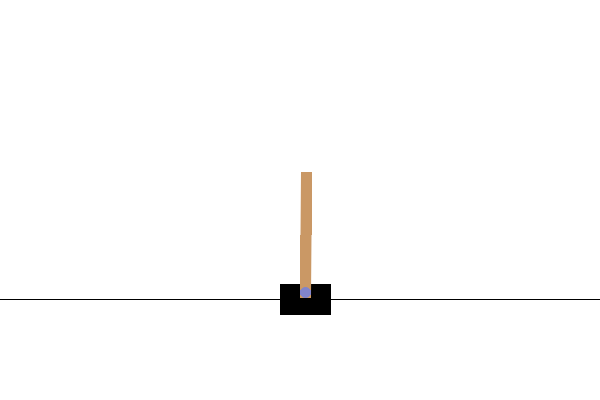

In [89]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

test_q_network_agent(env, q_network, num_episode=5)

env.close()

env.render_wrapper.make_gif("lab6_dqn_naive_untained")

#### Implement the epsilon greedy function

**Task 2.4:** Now, let's proceed to implement the epsilon-greedy strategy, which is a crucial component in balancing exploration and exploitation during the learning process of our reinforcement learning agent. To accomplish this, complete the `__call__` function in the following code block.

In [90]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : gym.Env
        The environment in which the agent is acting.
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay:float,
                 env: gym.Env,
                 q_network: torch.nn.Module):
        """
        Initialize a new instance of EpsilonGreedy.

        Parameters
        ----------
        epsilon_start : float
            The initial probability of choosing a random action.
        epsilon_min : float
            The minimum probability of choosing a random action.
        epsilon_decay : float
            The decay rate for the epsilon value after each episode.
        env : gym.Env
            The environment in which the agent is acting.
        q_network : torch.nn.Module
            The Q-Network used to estimate action values.
        """
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : np.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """

        # TODO...
        if np.random.rand() < self.epsilon:
            action = self.env.action_space.sample()  # Random action
        else:
            with torch.no_grad():
                q_values = self.q_network(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
            action = q_values.argmax().item()

        return action

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

#### Implementing a Learning Rate Scheduler

The following cell introduces a PyTorch Learning Rate (LR) scheduler. This scheduler is used for managing and adjusting the learning rate throughout the training process of our agent. It's designed to adjust the learning rate of an optimizer at each epoch, following an exponential decay strategy, but with a lower limit on the learning rate.

In [91]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

#### Implementing the Training Function

The following function is the final component of our initial agent. It orchestrates the training process, enabling the agent to learn from its interactions with the environment.

During each episode, the agent selects actions based on an epsilon-greedy policy, observes the next state and reward from the environment, and updates the weights of the Q-Network based on the observed reward and the maximum predicted Q-value of the next state.

**Task 2.5:** complete this function

In [92]:
def train_naive_agent(env: gym.Env,
                      q_network: torch.nn.Module,
                      optimizer: torch.optim.Optimizer,
                      loss_fn: Callable,
                      epsilon_greedy: EpsilonGreedy,
                      device: torch.device,
                      lr_scheduler: _LRScheduler,
                      num_episodes: int,
                      gamma: float) -> List[float]:
    """
    Train the Q-network on the given environment.

    Parameters
    ----------
    env : gym.Env
        The environment to train on.
    q_network : torch.nn.Module
        The Q-network to train.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : callable
        The loss function to use for training.
    epsilon_greedy : EpsilonGreedy
        The epsilon-greedy policy to use for action selection.
    device : torch.device
        The device to use for PyTorch computations.
    lr_scheduler : torch.optim.lr_scheduler._LRScheduler
        The learning rate scheduler to adjust the learning rate during training.
    num_episodes : int
        The number of episodes to train for.
    gamma : float
        The discount factor for future rewards.

    Returns
    -------
    List[float]
        A list of cumulated rewards per episode.
    """
    episode_reward_list = []

    for episode_index in tqdm(range(1, num_episodes)):
        state, info = env.reset()
        episode_reward = 0

        for t in itertools.count():

            # TODO...
            action = epsilon_greedy(state)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated


            # Update episode reward
            episode_reward += reward

            # Convert state and next_state to PyTorch tensors
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

            # Compute target Q-value using the Bellman equation
            with torch.no_grad():
                target_q_value = reward + gamma * q_network(next_state_tensor).max(dim=1)[0] * (1 - done)

            # Compute predicted Q-value for the current state
            predicted_q_value = q_network(state_tensor)[0, action]

            # Compute loss
            loss = loss_fn(predicted_q_value, target_q_value)

            # Perform optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Move to the next state
            state = next_state

            # Check if episode is done
            if done:
                break

        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()

    return episode_reward_list

#### Train the agent

In [93]:
env = gym.make('CartPole-v1')

# NUMBER_OF_TRAININGS = 20
naive_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Instantiate required objects

    q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    # Train the q-network

    episode_reward_list = train_naive_agent(env,
                                            q_network,
                                            optimizer,
                                            loss_fn,
                                            epsilon_greedy,
                                            device,
                                            lr_scheduler,
                                            num_episodes=150,
                                            gamma=0.9)
    naive_trains_result_list[0].extend(range(len(episode_reward_list)))
    naive_trains_result_list[1].extend(episode_reward_list)
    naive_trains_result_list[2].extend([train_index for _ in episode_reward_list])

naive_trains_result_df = pd.DataFrame(np.array(naive_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
naive_trains_result_df["agent"] = "Naive"

# Save the action-value estimation function of the last train

torch.save(q_network, "naive_q_network.pth")

env.close()

  0%|          | 0/149 [00:00<?, ?it/s]

#### Plot results

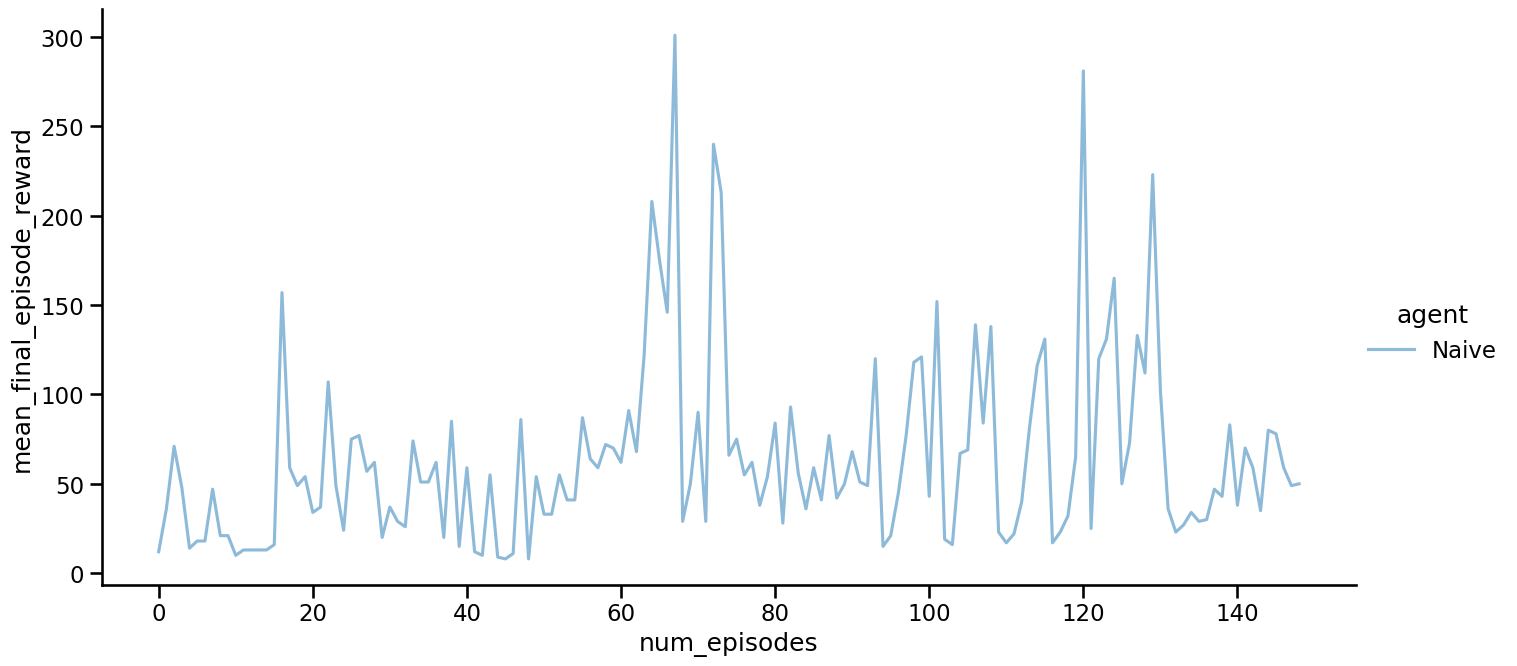

In [94]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=naive_trains_result_df,
                height=7, aspect=2, alpha=0.5);

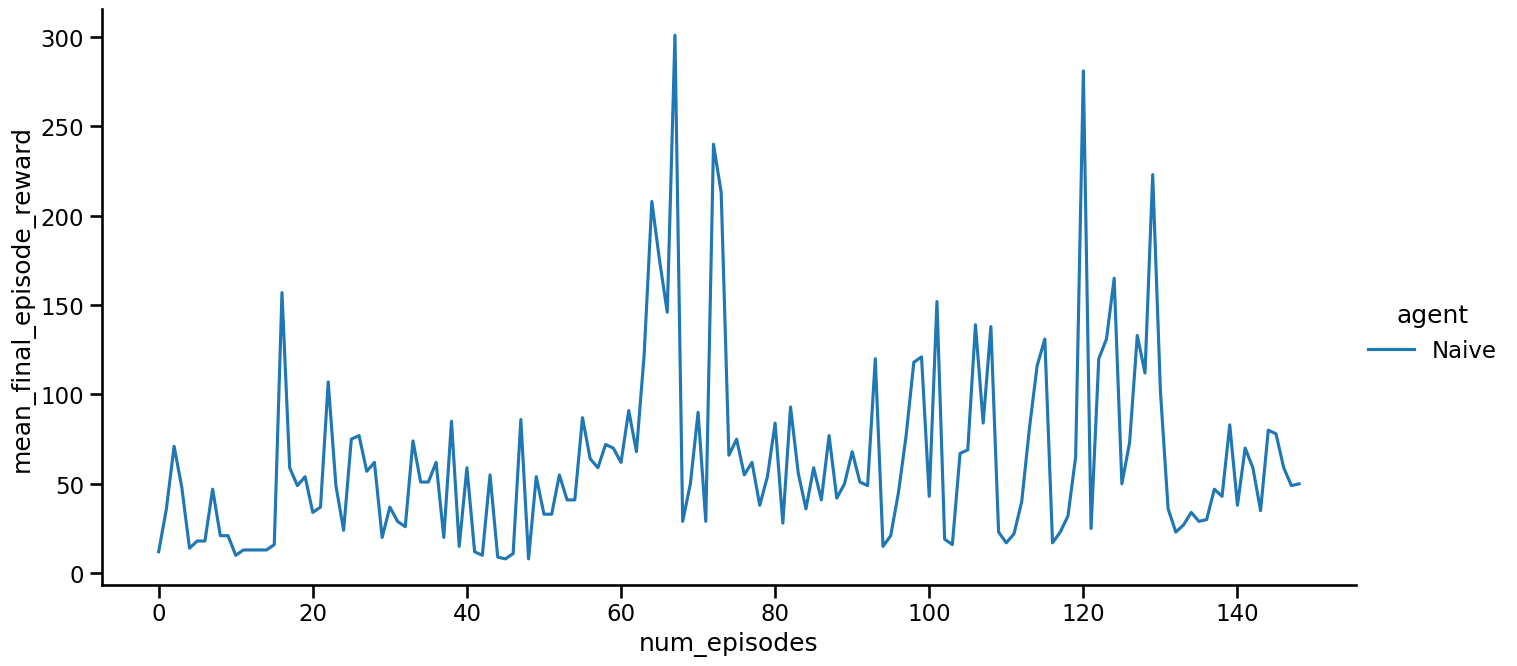

In [95]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=naive_trains_result_df, height=7, aspect=2)

#### Test it

Episode reward: 55.0
Episode reward: 52.0
Episode reward: 46.0
Episode reward: 36.0
Episode reward: 50.0


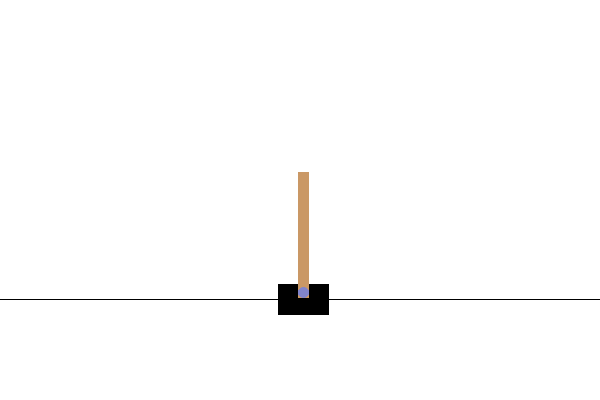

In [96]:
# q_network = torch.load("naive_q_network.pth").to(device)

env = gym.make('CartPole-v1', render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

test_q_network_agent(env, q_network, num_episode=5)

env.close()

env.render_wrapper.make_gif("lab6_dqn_naive_tained")

#### Why It Doesn't Work: The Complexity of Deep Reinforcement Learning

Our initial deep value-based agent did not converge, primarily due to the three fundamental challenges of value-based deep reinforcement learning:

1. **Coverage**: Convergence to the optimal Q-function relies on comprehensive coverage of the state space. However, in the context of deep RL, the state space is often too large to be fully covered. In situations where not all states are sampled due to their vast number, the guarantee of convergence no longer holds.

2. **Correlation**: The probability of transitioning to the next state is highly influenced by the current state. This strong correlation can lead to local overfitting and the risk of becoming trapped in a local optimum: the neural network, which approximates the Q-function, may become overly specialized in a small portion of the action-state space and neglect the rest.

3. **Convergence**: The "targets" used as the truth to be achieved "move" during the learning process. For the same prediction (estimation of the value of a state-action pair, i.e., its Q-value), the loss of a given example changes during the learning process (due to *bootstrapping* a main concept of TD-Learning). In other words, DQN tries to minimize a moving target, a target that depends on the model we are learning and optimizing. This can lead to instability and make it difficult for the learning process to converge to an optimal policy.

In the following sections, we will explore strategies to address these challenges and improve the performance of our deep reinforcement learning agent.

### Exercise 3: Implement Deep Q-Networks v1 (DQN version 2013 with experience replay)

In 2013, DeepMind made a significant contribution to the field of reinforcement learning with the publication of the paper "Playing Atari with Deep Reinforcement Learning" by Volodymyr Mnih and al (https://arxiv.org/abs/1312.5602). This paper marked the introduction of the first version of Deep Q-Networks (DQN).

The paper's primary innovation was the development of a technique to decorrelate states in reinforcement learning. This technique, known as *experience replay*, leverages a *replay buffer* to store and sample experiences. The introduction of experience replay greatly enhanced the stability and efficiency of the learning process.

#### Experience replay

Experience replay is a key technique used in Deep Q-Networks (DQN) to address the issues of correlation.

In a typical reinforcement learning setup, an agent learns by interacting with the environment, receiving feedback in the form of rewards, and updating its policy based on this feedback. This process is inherently sequential and the successive states are highly correlated, which can lead to overfitting and instability in learning.

Experience replay addresses these issues by storing the agent's experiences, i.e., the tuples of (state, action, reward, next state), in a data structure known as a replay buffer. During the learning process, instead of learning from the most recent experience, the agent randomly samples a batch of experiences from the replay buffer. This random sampling breaks the correlation between successive experiences, leading to more stable and robust learning.

Also, by learning from past experiences, the agent can effectively learn from a fixed target, which mitigates the issue of learning from a moving target. This is because the experiences in the replay buffer remain fixed once they are stored, even though the agent's policy continues to evolve.

#### DQN v2013 Algorithm

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\gamma$<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br>
	$\quad\quad$ capacity of the experience replay memory $M$<br>
	$\quad\quad$ batch size $m$<br><br>

<b>Initialize</b> replay memory $\mathcal{D}$ to capacity $M$<br>
<b>Initialize</b> action-value function $\hat{Q}$ with random weights $\mathbf{\omega}$<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\mathbf{s} \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $\mathbf{a} \leftarrow \epsilon\text{-greedy}(\mathbf{s}, \hat{Q}_{\mathbf{\omega}}$ $)$<br>
		$\quad\quad$ $r, \mathbf{s'} \leftarrow \text{env.step}(\mathbf{a})$<br>
		$\quad\quad$ Store transition $(\mathbf{s}, \mathbf{a}, r, \mathbf{s'})$ in $\mathcal{D}$<br>
		$\quad\quad$ Sample random batch of transitions $(\mathbf{s}_j, \mathbf{a}_j, r_j, \mathbf{s'}_j)$ from $\mathcal{D}$<br>
		$\quad\quad$ Set $y_j =
		\begin{cases}
		r_j & \text{for terminal } \mathbf{s'}_j\\
		r_j + \gamma \max_{\mathbf{a}^\star}\hat{Q}_{\mathbf{\omega}}(\mathbf{s'}_j)_{\mathbf{a}^\star} & \text{for non-terminal } \mathbf{s'}_j
		\end{cases}$<br>
		$\quad\quad$ Perform a gradient descent step on $\left( y_j - \hat{Q}_{\mathbf{\omega}}(\mathbf{s}_j)_{\mathbf{a}_j} \right)^2$ with respect to the weights $\mathbf{\omega}$<br>
		$\quad\quad$ $\mathbf{s} \leftarrow \mathbf{s'}$ <br>
	$\quad$ <b>UNTIL</b> $\mathbf{s}$ is final<br><br>
<b>RETURN</b> $\mathbf{\omega}$ <br>


#### Implement the Replay Buffer

To incorporate experience replay into the provided naive deep value-based reinforcement learning agent definition, we need to introduce a memory buffer where experiences are stored, and then update the algorithm to sample a random batch of experiences from this buffer to update the weights.

In [97]:
class ReplayBuffer:
    """
    A Replay Buffer.

    Attributes
    ----------
    buffer : collections.deque
        A double-ended queue where the transitions are stored.

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    __len__()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        """
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool):
        """
        Add a new transition to the buffer.

        Parameters
        ----------
        state : np.ndarray
            The state vector of the added transition.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : np.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[np.ndarray, float, float, np.ndarray, bool]
            A batch of `batch_size` transitions.
        """
        # Here, `random.sample(self.buffer, batch_size)`
        # returns a list of tuples `(state, action, reward, next_state, done)`
        # where:
        # - `state`  and `next_state` are numpy arrays
        # - `action` and `reward` are floats
        # - `done` is a boolean
        #
        # `states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))`
        # generates 5 tuples `state`, `action`, `reward`, `next_state` and `done`, each having `batch_size` elements.
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

#### Implement the training function

The training function of our initial deep value-based agent needs to be modified to incorporate the use of the replay buffer effectively.

1. **Store Experiences**: After the agent takes an action and receives a reward and the next state from the environment, store this experience in the replay buffer.

2. **Sample Experiences**: Instead of using the most recent experience to update the agent's policy, randomly sample a batch of experiences from the replay buffer.

3. **Compute Loss and Update Weights**: Use the sampled experiences to compute the loss and update the weights of the Q-Network.

4. **Handle Terminal States**: If the 'done' flag of an experience is True, indicating a terminal state, make sure to adjust the target Q-value to be just the received reward. This is because there are no future rewards possible after a terminal state.

**Task 3.1:** complete the `train_dqn1_agent` to use the replay buffer.

In [98]:
def train_dqn1_agent(env: gym.Env,
                     q_network: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     loss_fn: Callable,
                     epsilon_greedy: EpsilonGreedy,
                     device: torch.device,
                     lr_scheduler: _LRScheduler,
                     num_episodes: int,
                     gamma: float,
                     batch_size: int,
                     replay_buffer: ReplayBuffer) -> List[float]:
    """
    Train the Q-network on the given environment.

    Parameters
    ----------
    env : gym.Env
        The environment to train on.
    q_network : torch.nn.Module
        The Q-network to train.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : callable
        The loss function to use for training.
    epsilon_greedy : EpsilonGreedy
        The epsilon-greedy policy to use for action selection.
    device : torch.device
        The device to use for PyTorch computations.
    lr_scheduler : torch.optim.lr_scheduler._LRScheduler
        The learning rate scheduler to adjust the learning rate during training.
    num_episodes : int
        The number of episodes to train for.
    gamma : float
        The discount factor for future rewards.
    batch_size : int
        The size of the batch to use for training.
    replay_buffer : ReplayBuffer
        The replay buffer storing the experiences with their priorities.

    Returns
    -------
    List[float]
        A list of cumulated rewards per episode.
    """
    episode_reward_list = []

    for episode_index in tqdm(range(1, num_episodes)):
        state, info = env.reset()
        episode_reward = 0

        for t in itertools.count():

            # Get action, next_state and reward

            action = epsilon_greedy(state)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # TODO...
            replay_buffer.add(state, action, reward, next_state, done)
            if len(replay_buffer) >= batch_size:
                # Sample a batch of experiences from the replay buffer
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                # Convert numpy arrays to tensors and move to device
                states = torch.tensor(states, dtype=torch.float32, device=device)
                actions = torch.tensor(actions, dtype=torch.int64, device=device)
                rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
                next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
                dones = torch.tensor(dones, dtype=torch.bool, device=device)

                # Compute Q-values for current states
                q_values = q_network(states)

                # Compute target Q-values using the DQN target formula
                with torch.no_grad():
                    next_q_values = q_network(next_states)
                    target_q_values = rewards + (1 - dones.float()) * gamma * next_q_values.max(dim=1)[0]

                # Compute loss
                loss = loss_fn(q_values.gather(1, actions.unsqueeze(1)), target_q_values.unsqueeze(1))

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                lr_scheduler.step()

            episode_reward += reward

            if done:
                break

            state = next_state

        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()

    return episode_reward_list

#### Train it

In [99]:
env = gym.make('CartPole-v1')

# NUMBER_OF_TRAININGS = 20
dqn1_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Instantiate required objects

    q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn1_agent(env,
                                           q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=150,
                                           gamma=0.9,
                                           batch_size=128,
                                           replay_buffer=replay_buffer)
    dqn1_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn1_trains_result_list[1].extend(episode_reward_list)
    dqn1_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn1_trains_result_df = pd.DataFrame(np.array(dqn1_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn1_trains_result_df["agent"] = "DQN 2013"

# Save the action-value estimation function

torch.save(q_network, "dqn1_q_network.pth")

env.close()

  0%|          | 0/149 [00:00<?, ?it/s]

In [100]:
len(replay_buffer)

2000

#### Plot results

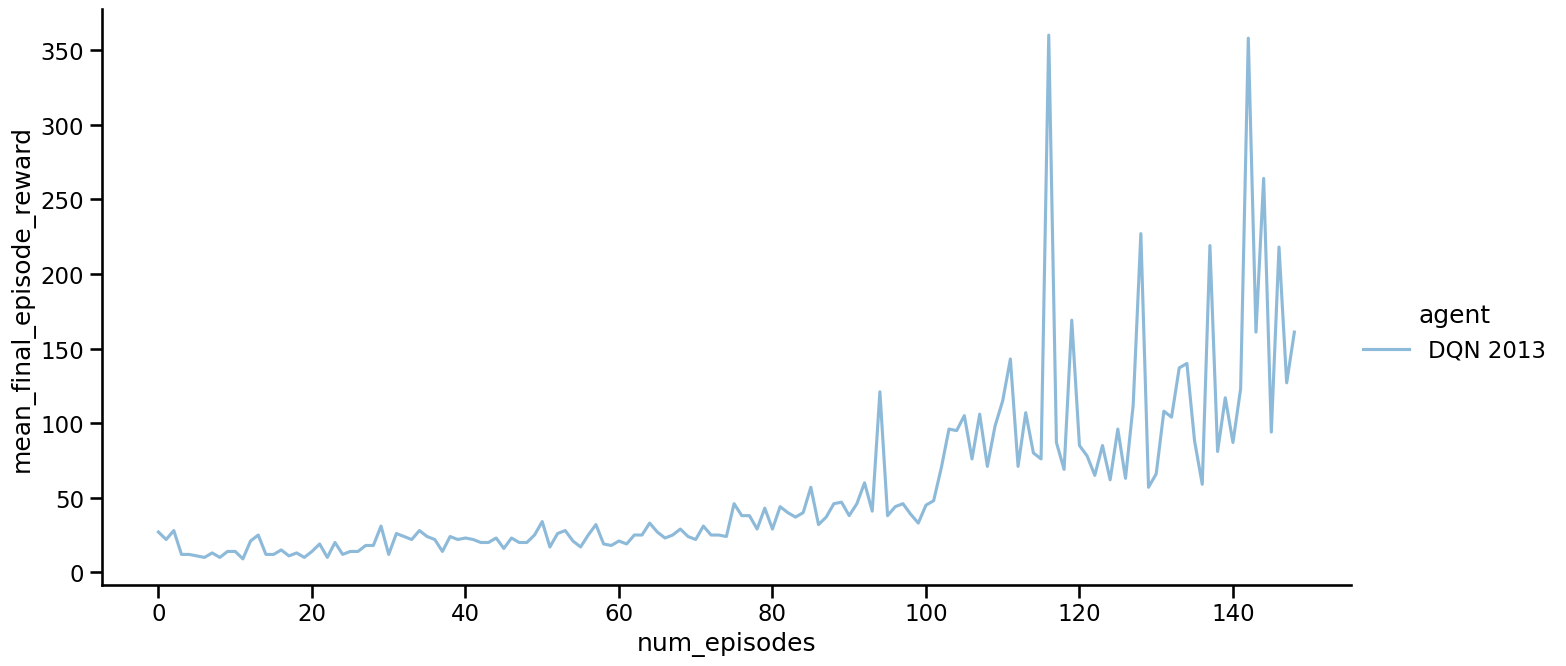

In [101]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn1_trains_result_df,
                height=7, aspect=2, alpha=0.5);

In [102]:
#g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", data=dqn1_trains_result_df, height=7, aspect=2)

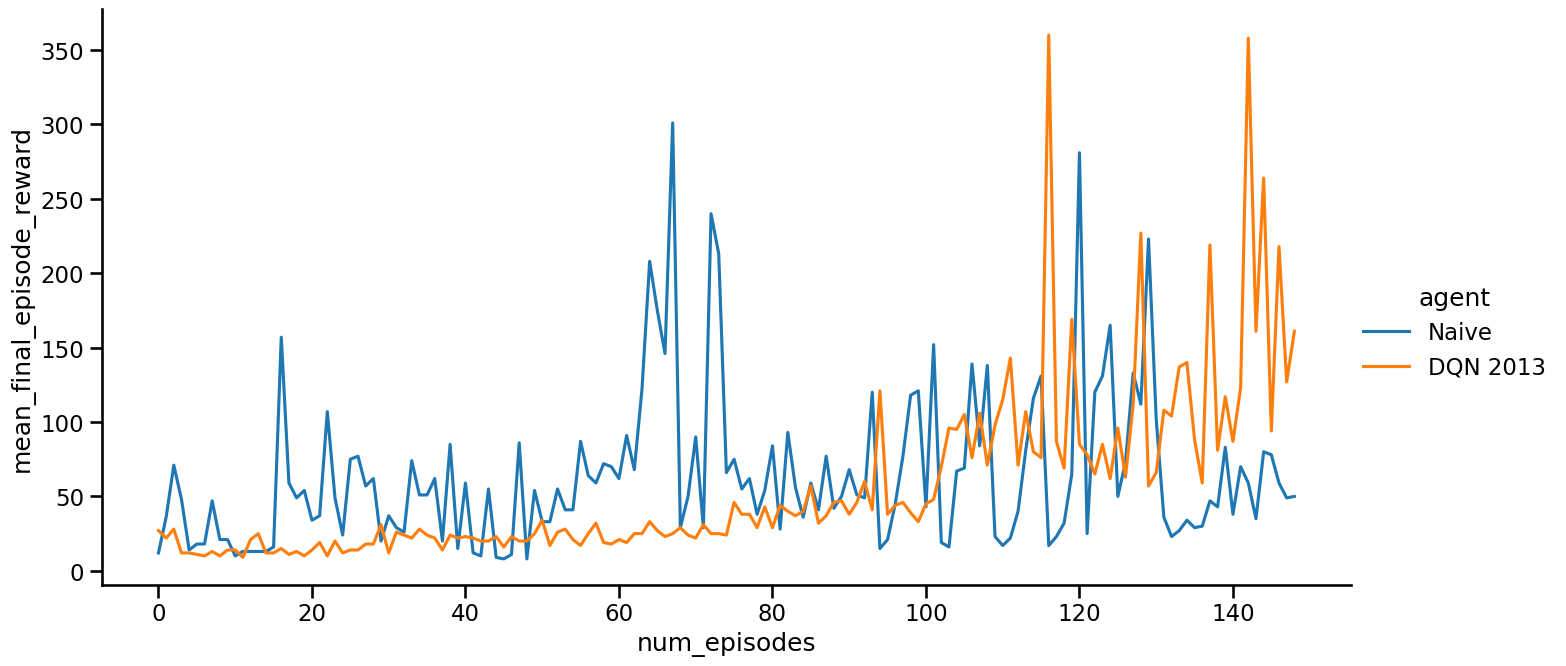

In [103]:
all_trains_result_df = pd.concat([naive_trains_result_df, dqn1_trains_result_df])
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", data=all_trains_result_df, height=7, aspect=2)

#### Test it

Episode reward: 79.0
Episode reward: 59.0
Episode reward: 67.0


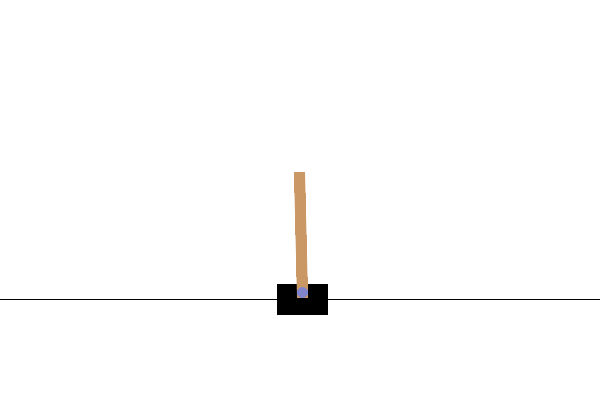

In [104]:
# q_network = torch.load("dqn1_q_network.pth").to(device)

env = gym.make('CartPole-v1', render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

test_q_network_agent(env, q_network, num_episode=3)

env.close()

env.render_wrapper.make_gif("lab6_dqn1_tained")

#### Score

In [105]:
score_ex3 = dqn1_trains_result_df[["num_episodes", "mean_final_episode_reward"]].groupby("num_episodes").mean().max()
score_ex3

mean_final_episode_reward    360.0
dtype: float64

### Exercise 4: Implement Deep Q-Networks v2 (DQN version 2015) with *infrequent weight updates*

In 2015, DeepMind further advanced the field of reinforcement learning with the publication of the paper "Human-level control through deep reinforcement learning" by Volodymyr Mnih and colleagues (https://www.nature.com/articles/nature14236). This work introduced the second version of Deep Q-Networks (DQN).

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-inf581-2024-students/master/lab6_dqn_nature_journal.jpg" width="200px" />

The key contribution of this paper was the introduction of a method to stabilize the learning process by infrequently updating the target weights. This technique, known as *infrequent updates of target weights*, significantly improved the stability of the learning process.

#### Infrequent weight updates

Infrequent weight updates, also known as the use of a target network, is a technique used in Deep Q-Networks (DQN) to address the issue of learning from a moving target.

In a typical DQN setup, there are two neural networks: the Q-network and the target network. The Q-network is used to predict the Q-values and is updated at every time step. The target network is used to compute the target Q-values for the update, and its weights are updated less frequently, typically every few thousand steps, by copying the weights from the Q-network.

The idea behind infrequent weight updates is to stabilize the learning process by keeping the target Q-values fixed for a number of steps. This mitigates the issue of learning from a moving target, as the target Q-values remain fixed between updates.

Without infrequent weight updates, both the predicted and target Q-values would change at every step, which could lead to oscillations and divergence in the learning process. By introducing a delay between updates of the target Q-values, the risk of such oscillations is reduced.

#### DQN v2015 Algorithm

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\gamma$<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br>
	$\quad\quad$ capacity of the experience replay memory $M$<br>
	$\quad\quad$ batch size $m$<br>
	$\quad\quad$ target network update frequency $\tau$<br><br>

<b>Initialize</b> replay memory $\mathcal{D}$ to capacity $M$<br>
<b>Initialize</b> action-value function $\hat{Q}$ with random weights $\mathbf{\omega}$<br>
<b>Initialize</b> target action-value function $\hat{Q}$ with weights $\mathbf{\omega_2} = \mathbf{\omega}$<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\mathbf{s} \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $\mathbf{a} \leftarrow \epsilon\text{-greedy}(\mathbf{s}, \hat{Q}_{\mathbf{\omega_1}}$ $)$<br>
		$\quad\quad$ $r, \mathbf{s'} \leftarrow \text{env.step}(\mathbf{a})$<br>
		$\quad\quad$ Store transition $(\mathbf{s}, \mathbf{a}, r, \mathbf{s'})$ in $\mathcal{D}$<br>
		$\quad\quad$ Sample random batch of transitions $(\mathbf{s}_j, \mathbf{a}_j, r_j, \mathbf{s'}_j)$ from $\mathcal{D}$<br>
		$\quad\quad$ For each $j$, set $y_j =
		\begin{cases}
		r_j & \text{for terminal } \mathbf{s'}_j\\
		r_j + \gamma \max_{\mathbf{a}^\star} \hat{Q}_{\mathbf{\omega_2}} (\mathbf{s'}_j)_{\mathbf{a}^\star} & \text{for non-terminal } \mathbf{s'}_j
		\end{cases}$<br>
		$\quad\quad$ Perform a gradient descent step on $\left( y_j - \hat{Q}_{\mathbf{\omega_1}}(\mathbf{s}_j)_{\mathbf{a}_j} \right)^2$ with respect to the weights $\mathbf{\omega_1}$<br>
		$\quad\quad$ Every $\tau$ steps reset $\hat{Q}_{\mathbf{\omega_2}}$ to $\hat{Q}_{\mathbf{\omega_1}}$, i.e., set $\mathbf{\omega_2} \leftarrow \mathbf{\omega_1}$<br>
		$\quad\quad$ $\mathbf{s} \leftarrow \mathbf{s'}$ <br>
	$\quad$ <b>UNTIL</b> $\mathbf{s}$ is final<br><br>
<b>RETURN</b> $\mathbf{\omega}$ <br>


#### Implement the training function

To incorporate the use of infrequent weight updates in the training function, you would need to make the following modifications:

1. **Update the Target Network Infrequently**: Instead of updating the weights of the target network at every time step, update them less frequently, for example, every few thousand steps. The weights of the target network are updated by copying the weights from the Q-network.

2. **Compute Target Q-values with the Target Network**: When computing the target Q-values for the update, use the target network instead of the Q-network. This ensures that the target Q-values remain fixed between updates, which stabilizes the learning process.

**Task 4.1:** complete the `train_dqn2_agent` to apply infrequent weight updates.

In [106]:
def train_dqn2_agent(env: gym.Env,
                     q_network: torch.nn.Module,
                     target_q_network: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     loss_fn: Callable,
                     epsilon_greedy: EpsilonGreedy,
                     device: torch.device,
                     lr_scheduler: _LRScheduler,
                     num_episodes: int,
                     gamma: float,
                     batch_size: int,
                     replay_buffer: ReplayBuffer,
                     target_q_network_sync_period: int) -> List[float]:
    """
    Train the Q-network on the given environment.

    Parameters
    ----------
    env : gym.Env
        The environment to train on.
    q_network : torch.nn.Module
        The Q-network to train.
    target_q_network : torch.nn.Module
        The target Q-network to use for estimating the target Q-values.
    optimizer : torch.optim.Optimizer
        The optimizer to use for training.
    loss_fn : callable
        The loss function to use for training.
    epsilon_greedy : EpsilonGreedy
        The epsilon-greedy policy to use for action selection.
    device : torch.device
        The device to use for PyTorch computations.
    lr_scheduler : torch.optim.lr_scheduler._LRScheduler
        The learning rate scheduler to adjust the learning rate during training.
    num_episodes : int
        The number of episodes to train for.
    gamma : float
        The discount factor for future rewards.
    batch_size : int
        The size of the batch to use for training.
    replay_buffer : ReplayBuffer
        The replay buffer storing the experiences with their priorities.
    target_q_network_sync_period : int
        The number of episodes after which the target Q-network should be updated with the weights of the Q-network.

    Returns
    -------
    List[float]
        A list of cumulated rewards per episode.
    """
    iteration = 0
    episode_reward_list = []

    for episode_index in tqdm(range(1, num_episodes)):
        state, info = env.reset()
        episode_reward = 0

        for t in itertools.count():

            # Get action, next_state and reward

            action = epsilon_greedy(state)

            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            replay_buffer.add(state, action, reward, next_state, done)

            episode_reward += reward

            # Update the q_network weights with a batch of experiences from the buffer

            if len(replay_buffer) > batch_size:
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample(batch_size)

                # Convert to PyTorch tensors
                batch_states_tensor = torch.tensor(batch_states, dtype=torch.float32, device=device)
                batch_actions_tensor = torch.tensor(batch_actions, dtype=torch.long, device=device)
                batch_rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
                batch_next_states_tensor = torch.tensor(batch_next_states, dtype=torch.float32, device=device)
                batch_dones_tensor = torch.tensor(batch_dones, dtype=torch.float32, device=device)

                # TODO...
                q_values = q_network(batch_states_tensor)
                q_values_next = target_q_network(batch_next_states_tensor).detach()

                target_q_values = batch_rewards_tensor + (1 - batch_dones_tensor) * gamma * q_values_next.max(1)[0]
                q_values_predicted = q_values.gather(1, batch_actions_tensor.unsqueeze(1)).squeeze()
                loss = loss_fn(q_values_predicted, target_q_values)

                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                lr_scheduler.step()

            # Update the target q-network

            # Every few training steps (e.g., every 100 steps), the weights of the target network are updated with the weights of the Q-network

            # TODO...

            iteration += 1
            if iteration % target_q_network_sync_period == 0:
                    target_q_network.load_state_dict(q_network.state_dict())

            if done:
                break

            state = next_state

        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()

    return episode_reward_list

#### Train it

In order to test this new implementation, we needs de adapt the following cell to instantiate and initialize the two neural networks.

**Task 4.2:** complete the following cell to make the two Q-Networks. Initialize a target network that has the same architecture as the Q-network. The weights of the target network are initially copied from the Q-network.

In [107]:
env = gym.make('CartPole-v1')

# NUMBER_OF_TRAININGS = 20
dqn2_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Instantiate required objects

    # TODO...
    q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
    target_q_network = QNetwork(state_dim, action_dim, nn_l1=128, nn_l2=128).to(device)
    target_q_network.load_state_dict(q_network.state_dict())

    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.97, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.82, epsilon_min=0.013, epsilon_decay=0.9675, env=env, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn2_agent(env,
                                           q_network,
                                           target_q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=150,
                                           gamma=0.9,
                                           batch_size=128,
                                           replay_buffer=replay_buffer,
                                           target_q_network_sync_period=30)
    dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn2_trains_result_list[1].extend(episode_reward_list)
    dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

dqn2_trains_result_df = pd.DataFrame(np.array(dqn2_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

# Save the action-value estimation function

torch.save(q_network, "dqn2_q_network.pth")

env.close()

  0%|          | 0/149 [00:00<?, ?it/s]

#### Plot results

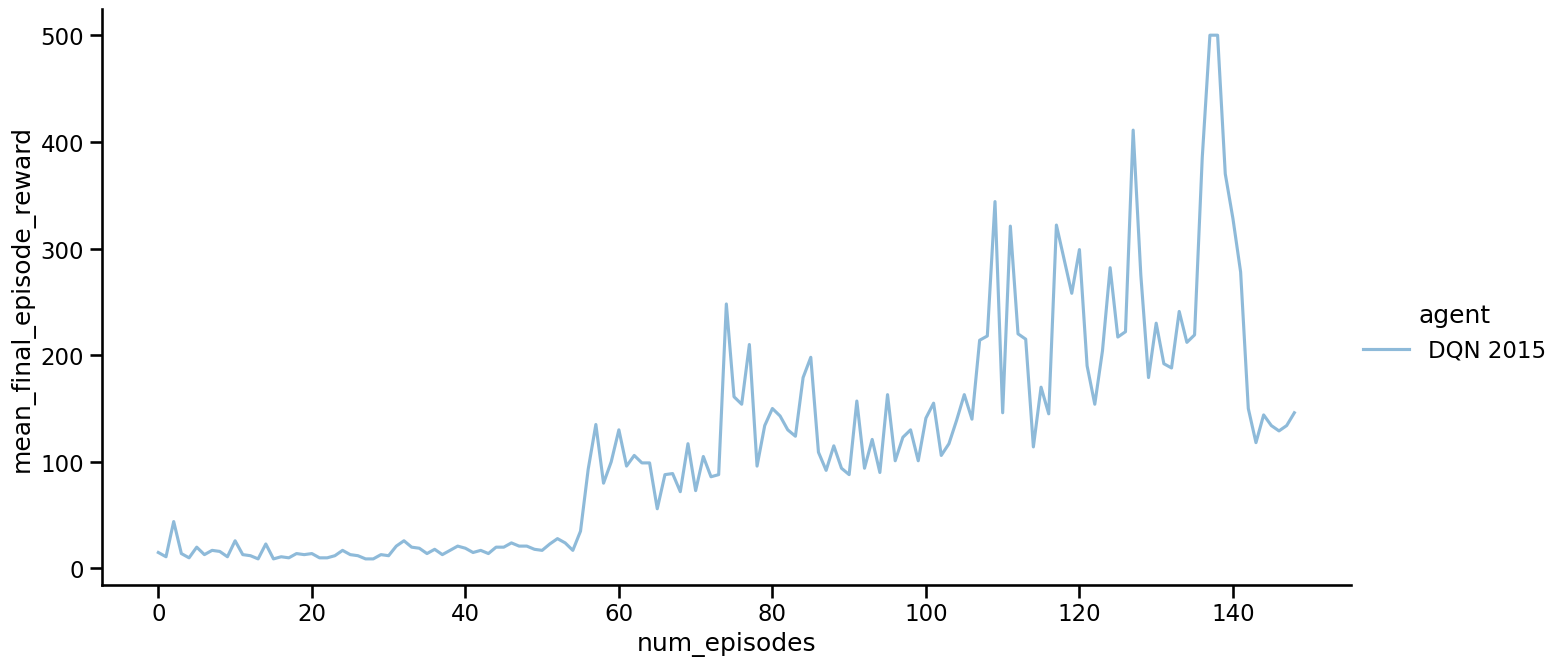

In [108]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=dqn2_trains_result_df,
                height=7, aspect=2, alpha=0.5);

In [109]:
#g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", data=dqn2_trains_result_df, height=7, aspect=2)

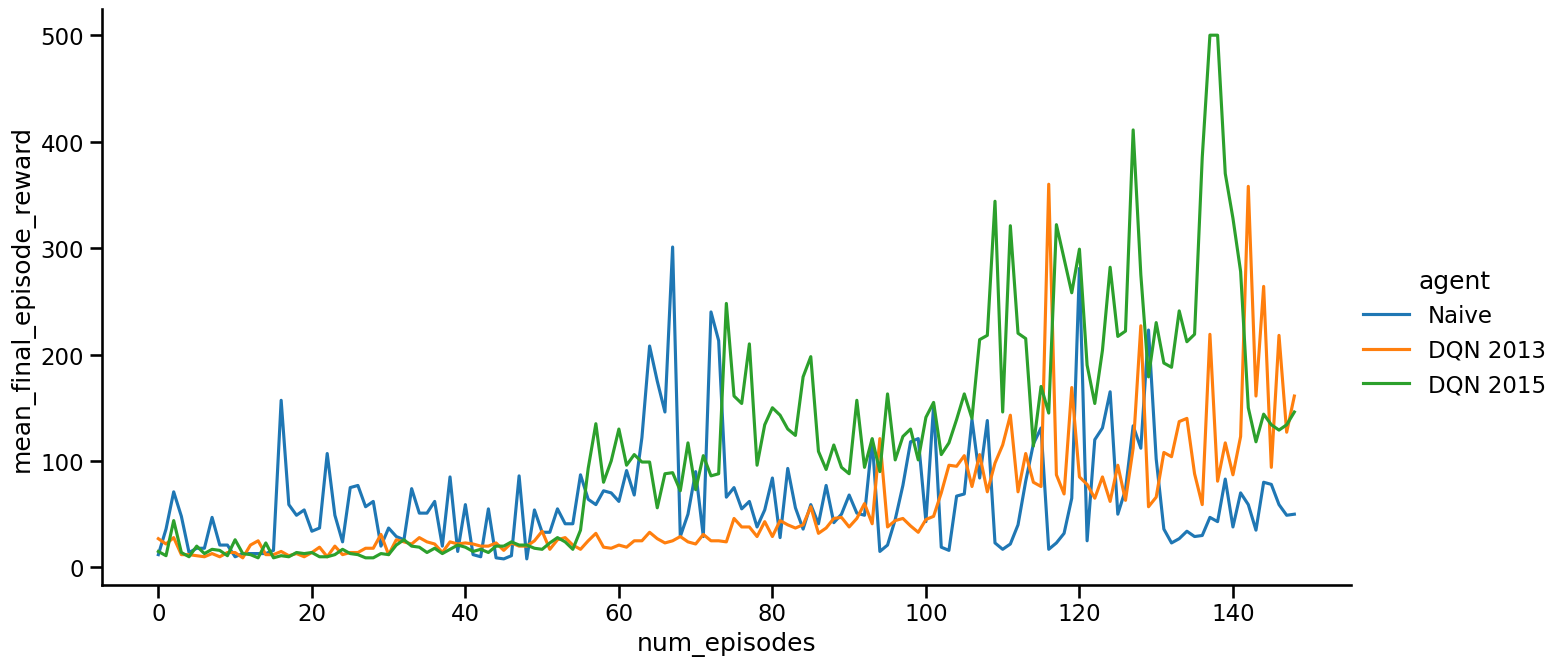

In [110]:
all_trains_result_df = pd.concat([naive_trains_result_df, dqn1_trains_result_df, dqn2_trains_result_df])
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", data=all_trains_result_df, height=7, aspect=2)

#### Test it

Episode reward: 114.0
Episode reward: 136.0
Episode reward: 123.0


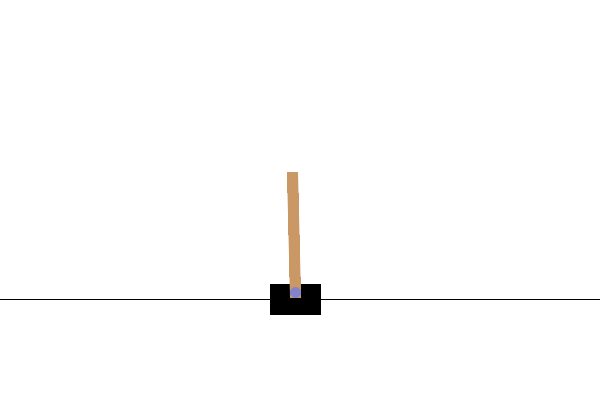

In [111]:
# q_network = torch.load("dqn2_q_network.pth").to(device)

env = gym.make('CartPole-v1', render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

test_q_network_agent(env, q_network, num_episode=3)

env.close()

env.render_wrapper.make_gif("lab6_dqn2_tained")

#### Score

In [112]:
score_ex4 = dqn2_trains_result_df[["num_episodes", "mean_final_episode_reward"]].groupby("num_episodes").mean().max()
score_ex4

mean_final_episode_reward    500.0
dtype: float64

## Part 3: Deep policy-based reinforcement learning with Monte Carlo Policy Gradient (REINFORCE)

In the previous part, we explored DQN, a value-based method that can be used to solve Reinforcement Learning problems having large state spaces.
Now, we will solve the CartPole environment using a policy gradient method which directly searchs in a family of parameterized policies $\pi_\theta$ for the optimal policy.


### The Policy Gradient theorem

Policy Gradient methods performs gradient ascent in the policy space so that the total return is maximized.
We will restrict our work to episodic tasks, *i.e.* tasks that have a starting states and last for a finite and fixed number of steps $T$, called horizon.

More formally, we define an optimization criterion that we want to maximize:

$$J(\theta) = \mathbb{E}_{\pi_\theta}\left[\sum_{t=1}^T r(s_t,a_t)\right],$$

where $\mathbb{E}_{\pi_\theta}$ means $a \sim \pi_\theta(s,.)$ and $T$ is the horizon of the episode.
In other words, we want to maximize the value of the starting state: $V^{\pi_\theta}(s)$.
The policy gradient theorem tells us that:

$$
\nabla_\theta J(\theta) = \nabla_\theta V^{\pi_\theta}(s) = \mathbb{E}_{\pi_\theta} \left[\nabla_\theta \log \pi_\theta (s,a) ~ Q^{\pi_\theta}(s,a) \right],
$$

where the $Q$-function is defined as:

$$Q^{\pi_\theta}(s,a) = \mathbb{E}^{\pi_\theta} \left[\sum_{t=1}^T r(s_t,a_t)|s=s_1, a=a_1\right].$$

The policy gradient theorem is particularly effective because it allows gradient computation without needing to understand the system's dynamics, as long as the $Q$-function for the current policy is computable. By simply applying the policy and observing the one-step transitions, sufficient information is gathered. Implementing a stochastic gradient ascent and substituting $Q^{\pi_\theta}(s_t,a_t)$ with a Monte Carlo estimate $R_t = \sum_{t'=t}^T r(s_{t'},a_{t'})$ for a single trajectory, we derive the REINFORCE algorithm.

The REINFORCE algorithm, introduced by Williams in 1992, is a Monte Carlo policy gradient method. It updates the policy in the direction that maximizes rewards, using full-episode returns as an unbiased estimate of the gradient. Each step involves generating an episode using the current policy, computing the gradient estimate, and updating the policy parameters. This algorithm is simple yet powerful, and it's particularly effective in environments where the policy gradient is noisy or the dynamics are complex.

For further reading and a deeper understanding, refer to Williams' seminal paper (https://link.springer.com/article/10.1007/BF00992696) and the comprehensive text on reinforcement learning by Richard S. Sutton and Andrew G. Barto: "Reinforcement Learning: An Introduction", chap.13 (http://incompleteideas.net/book/RLbook2020.pdf).

Here is the REINFORCE algorithm.

### Monte Carlo policy gradient (REINFORCE)

<b>REQUIRE</b> <br>
$\quad$ A differentiable policy $\pi_{\boldsymbol{\theta}}$ <br>
$\quad$ A learning rate $\alpha \in \mathbb{R}^+$ <br>
<b>INITIALIZATION</b> <br>
$\quad$ Initialize parameters $\boldsymbol{\theta} \in \mathbb{R}^d$ <br>
<br>
<b>FOR EACH</b> episode <br>
$\quad$ Generate full trace $\tau = \{ \boldsymbol{s}_0, \boldsymbol{a}_0, r_1, \boldsymbol{s}_1, \boldsymbol{a}_1, \dots, r_T, \boldsymbol{s}_T \}$ following $\pi_{\boldsymbol{\theta}}$ <br>
$\quad$ <b>FOR</b> $~ t=0,\dots,T-1$ <br>
$\quad\quad$ $G \leftarrow \sum_{k=t}^{T-1} r_k$ <br>
$\quad\quad$ $\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \alpha ~ \underbrace{G ~ \nabla_{\boldsymbol{\theta}} \ln \pi_{\boldsymbol{\theta}}(\boldsymbol{a}_t|\boldsymbol{s}_t)}_{\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})}$ <br>
<br>
<b>RETURN</b> $\boldsymbol{\theta}$

### Exercise 5: REINFORCE for discrete action spaces (Cartpole)

#### Policy Implementation

We will implement a stochastic policy to control the cart using a simple one-layer neural network. Given the simplicity of the problem, a single layer will suffice. We will not incorporate a bias term in this layer.

This neural network will output the probabilities of each possible action (in this case, there are only two actions: "push left" or "push right") given the input vector $s$ (the 4-dimensional state vector).

**Task 5.1**: Implement the `PolicyNetwork`  defined as follow.

The network takes an input tensor representing the state of the environment and outputs a tensor of action probabilities.
The network has the following components:

- `layer1`: This is a linear (fully connected) layer that takes `n_observations` as input and outputs `n_actions`. It does not include a bias term.

- `forward` method: This method defines the forward pass of the network. It takes a state tensor as input and returns a tensor of action probabilities. It first applies the linear layer to the input state tensor to get the logits (the raw, unnormalized scores for each action), and then applies the softmax function to the logits to get the action probabilities. The softmax function ensures that the action probabilities are positive and sum to 1, so they can be interpreted as probabilities.

This network is quite simple and may not perform well on complex tasks with large state or action spaces. However, it can be a good starting point for simple reinforcement learning tasks, and can be easily extended with more layers or different types of layers (such as convolutional layers for image inputs) to handle more complex tasks.

In [113]:
class PolicyNetwork(torch.nn.Module):
    """
    A neural network used as a policy for the REINFORCE algorithm.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        A fully connected layer.

    Methods
    -------
    forward(state: torch.Tensor) -> torch.Tensor
        Define the forward pass of the PolicyNetwork.
    """

    def __init__(self, n_observations: int, n_actions: int):
        """
        Initialize a new instance of PolicyNetwork.

        Parameters
        ----------
        n_observations : int
            The size of the observation space.
        n_actions : int
            The size of the action space.
        """
        super(PolicyNetwork, self).__init__()

        # TODO...
        self.layer1 = torch.nn.Linear(n_observations, n_actions, bias=False)


    def forward(self, state_tensor: torch.Tensor) -> torch.Tensor:
        """
        Calculate the probability of each action for the given state.

        Parameters
        ----------
        state_tensor : torch.Tensor
            The input tensor (state).
            The shape of the tensor should be (N, dim),
            where N is the number of states vectors in the batch
            and dim is the dimension of state vectors.

        Returns
        -------
        torch.Tensor
            The output tensor (the probability of each action for the given state).
        """

        # TODO...
        out = self.layer1(state_tensor)
        out = torch.nn.functional.softmax(out, dim=-1)
        return out

**Task 5.2**: Complete the `sample_discrete_action` function. This function is used to sample a discrete action based on a given state and a policy network. It first converts the state into a tensor and passes it through the policy network to get the parameters of the action probability distribution. Then, it creates a categorical distribution from these parameters and samples an action from this distribution. It also calculates the log probability of the sampled action according to the distribution. The function returns the sampled action and its log probability.

In [114]:
def sample_discrete_action(policy_nn: PolicyNetwork,
                           state: NDArray[np.float64]) -> Tuple[int, torch.Tensor]:
    """
    Sample a discrete action based on the given state and policy network.

    This function takes a state and a policy network, and returns a sampled action and its log probability.
    The action is sampled from a categorical distribution defined by the output of the policy network.

    Parameters
    ----------
    policy_nn : PolicyNetwork
        The policy network that defines the probability distribution of the actions.
    state : NDArray[np.float64]
        The state based on which an action needs to be sampled.

    Returns
    -------
    Tuple[int, torch.Tensor]
        The sampled action and its log probability.

    """

    # TODO...
    state_tensor = torch.tensor(state, dtype=torch.float32)
    action_probs = policy_nn(state_tensor)
    categorical_dist = torch.distributions.Categorical(action_probs)
    sampled_action = categorical_dist.sample()
    sampled_action_log_probability = categorical_dist.log_prob(sampled_action)

    # Return the sampled action and its log probability.
    return sampled_action, sampled_action_log_probability

**Task 5.3**: Test the `sample_discrete_action` function on a random state using an untrained policy network.

In [115]:
env = gym.make('CartPole-v1')

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

# TODO...
policy_network = PolicyNetwork(state_size, action_size)
state = env.observation_space.sample()
theta, action_log_probability = sample_discrete_action(policy_network, state)


print("state:", state)
print("theta:", theta)
print("sampled action:", action)
print("log probability of the sampled action:", action_log_probability)

env.close()

state: [-3.7904054e-01  2.7279752e+38 -1.4357066e-01  2.7354243e+38]
theta: tensor(0)
sampled action: 1
log probability of the sampled action: tensor(-1.1921e-07, grad_fn=<SqueezeBackward1>)


#### Implement the sample_one_episode function

Remember that in the REINFORCE algorithm, we need to generate a complete trajectory, denoted as $\tau = \{ \boldsymbol{s}_0, \boldsymbol{a}_0, r_1, \boldsymbol{s}_1, \boldsymbol{a}_1, \dots, r_T, \boldsymbol{s}_T \}$. This trajectory includes the states, actions, and rewards at each time step, as outlined in the algorithm at the beginning of Part 1.

**Task 5.4**: Your task is to implement the `sample_one_episode` function. This function should play one episode using the given policy $\pi_\theta$ and return its rollouts. The function should adhere to a fixed horizon $T$, which represents the maximum number of steps in the episode.

In [116]:
def sample_one_episode(env: gym.Env,
                       policy_nn: PolicyNetwork,
                       max_episode_duration: int,
                       render: bool = False) -> Tuple[List[NDArray[np.float64]], List[int], List[float], List[torch.Tensor]]:
    """
    Execute one episode within the `env` environment utilizing the policy defined by the `policy_nn` parameter.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    max_episode_duration : int
        The maximum duration of the episode.
    render : bool, optional
        Whether to render the environment, by default False.

    Returns
    -------
    Tuple[List[NDArray[np.float64]], List[int], List[float], List[torch.Tensor]]
        The states, actions, rewards, and log probability of action for each time step in the episode.
    """
    state_t, info = env.reset()

    episode_states = []
    episode_actions = []
    episode_log_prob_actions = []
    episode_rewards = []
    episode_states.append(state_t)

    for t in range(max_episode_duration):

        if render:
            env.render_wrapper.render()
        # TODO...

        state_tensor = torch.tensor(state_t, dtype=torch.float32).unsqueeze(0)
        action_probs = policy_nn(state_tensor)
        action_dist = torch.distributions.Categorical(action_probs)
        action_t = action_dist.sample()
        log_prob_action_t = action_dist.log_prob(action_t)


        next_state_t, reward_t, terminated, truncated, info = env.step(action_t.item())
        done = terminated or truncated


        episode_states.append(next_state_t)
        episode_actions.append(action_t.item())
        episode_log_prob_actions.append(log_prob_action_t)
        episode_rewards.append(reward_t)

        state_t = next_state_t

        if done:
            break

    return episode_states, episode_actions, episode_rewards, episode_log_prob_actions

**Task 5.5:** Test this function on the untrained agent.

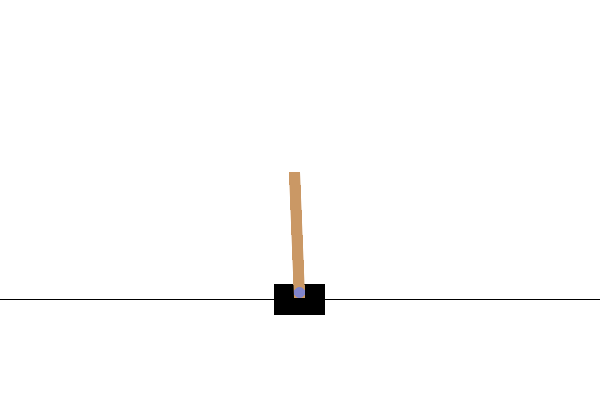

In [117]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

# TODO...
policy_nn = PolicyNetwork(state_size, action_size)
max_episode_duration = 200
episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, policy_nn, max_episode_duration, render=True)


env.close()
env.render_wrapper.make_gif("lab6_reinforce_untained")

In [118]:
episode_states

[array([-0.00714816,  0.00156827, -0.03427294, -0.02849352], dtype=float32),
 array([-0.00711679,  0.19716454, -0.03484281, -0.33178988], dtype=float32),
 array([-0.0031735 ,  0.00255541, -0.04147861, -0.05029509], dtype=float32),
 array([-0.00312239,  0.19824682, -0.04248451, -0.35577095], dtype=float32),
 array([ 0.00084254,  0.39394626, -0.04959993, -0.6615419 ], dtype=float32),
 array([ 0.00872147,  0.589722  , -0.06283077, -0.96942073], dtype=float32),
 array([ 0.02051591,  0.78562856, -0.08221918, -1.2811608 ], dtype=float32),
 array([ 0.03622848,  0.98169607, -0.1078424 , -1.5984138 ], dtype=float32),
 array([ 0.0558624 ,  0.7880047 , -0.13981068, -1.3412088 ], dtype=float32),
 array([ 0.07162249,  0.9845818 , -0.16663486, -1.6741679 ], dtype=float32),
 array([ 0.09131413,  0.7917403 , -0.20011821, -1.4376765 ], dtype=float32),
 array([ 0.10714894,  0.5995671 , -0.22887175, -1.2136124 ], dtype=float32)]

In [119]:
episode_actions

[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0]

In [120]:
episode_rewards

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#### Implement a test function

**Task 5.6**: Implement the `avg_return_on_multiple_episodes` function that test the given policy $\pi_\theta$ on `num_episodes` episodes (for fixed horizon $T$) and returns the average reward on the `num_episodes` episodes.

The function `avg_return_on_multiple_episodes` is designed to play multiple episodes of a given environment using a specified policy neural network and calculate the average return. It takes as input the environment to play in, the policy neural network to use, the number of episodes to play, the maximum duration of an episode, and an optional parameter to decide whether to render the environment or not.
In each episode, it uses the `sample_one_episode` function to play the episode and collect the rewards. The function then returns the average of these cumulated rewards.

`avg_return_on_multiple_episodes` will be used for evaluating the performance of a policy over multiple episodes.

In [121]:
def avg_return_on_multiple_episodes(env: gym.Env,
                                    policy_nn: PolicyNetwork,
                                    num_test_episode: int,
                                    max_episode_duration: int,
                                    render: bool = False) -> float:
    """
    Play multiple episodes of the environment and calculate the average return.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    num_test_episode : int
        The number of episodes to play.
    max_episode_duration : int
        The maximum duration of an episode.
    render : bool, optional
        Whether to render the environment, by default False.

    Returns
    -------
    float
        The average return.
    """

    # TODO...
    total_return = 0.0

    for _ in range(num_test_episode):
        # Sample one episode
        _, _, episode_rewards, _ = sample_one_episode(env, policy_nn, max_episode_duration, render)
        # Calculate the total return of the episode
        episode_return = sum(episode_rewards)
        total_return += episode_return

    # Calculate the average return over all episodes
    average_return = total_return / num_test_episode

    return average_return

**Task 5.7:** Test this function on the untrained agent.

In [122]:
env = gym.make("CartPole-v1")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

# TODO...
policy_nn = PolicyNetwork(n_observations=state_size, n_actions=action_size)
num_test_episodes = 10
max_episode_duration = 200
average_return = avg_return_on_multiple_episodes(env, policy_nn, num_test_episodes, max_episode_duration)


print(average_return)

env.close()

22.3


#### Implement the train function

**Task 5.8**: Implement the `train_reinforce_discrete` function, used to train a policy network using the REINFORCE algorithm in the given environment. This function takes as input the environment, the number of training episodes, the number of tests to perform per episode, the maximum duration of an episode, and the learning rate for the optimizer.

The function first initializes a policy network and an Adam optimizer. Then, for each training episode, it generates an episode using the current policy and calculates the return at each time step. It uses this return and the log probability of the action taken at that time step to compute the loss, which is the negative of the product of the return and the log probability. This loss is used to update the policy network parameters using gradient ascent.

After each training episode, the function tests the current policy by playing a number of test episodes and calculating the average return. This average return is added to a list for monitoring purposes.

The function returns the trained policy network and the list of average returns for each episode. This function encapsulates the main loop of the REINFORCE algorithm, including the policy update step. Please refer back to the algorithm outlined at the start of Part 3 for additional context, if necessary.

In [123]:
def train_reinforce_discrete(env: gym.Env,
                             num_train_episodes: int,
                             num_test_per_episode: int,
                             max_episode_duration: int,
                             learning_rate: float) -> Tuple[PolicyNetwork, List[float]]:
    """
    Train a policy using the REINFORCE algorithm.

    Parameters
    ----------
    env : gym.Env
        The environment to train in.
    num_train_episodes : int
        The number of training episodes.
    num_test_per_episode : int
        The number of tests to perform per episode.
    max_episode_duration : int
        The maximum length of an episode, by default EPISODE_DURATION.
    learning_rate : float
        The initial step size.

    Returns
    -------
    Tuple[PolicyNetwork, List[float]]
        The final trained policy and the average returns for each episode.
    """
    episode_avg_return_list = []

    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n.item()

    policy_nn = PolicyNetwork(state_size, action_size).to(device)
    optimizer = torch.optim.Adam(policy_nn.parameters(), lr=learning_rate)

    for episode_index in tqdm(range(num_train_episodes)):
        # TODO...
        episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, policy_nn, max_episode_duration)

        policy_loss = torch.stack([-log_prob_action * reward for log_prob_action, reward in zip(episode_log_prob_actions, episode_rewards)]).sum()
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Test the current policy
        test_avg_return = avg_return_on_multiple_episodes(env=env,
                                                          policy_nn=policy_nn,
                                                          num_test_episode=num_test_per_episode,
                                                          max_episode_duration=max_episode_duration,
                                                          render=False)

        # Monitoring
        episode_avg_return_list.append(test_avg_return)

    return policy_nn, episode_avg_return_list

#### Train the agent

In [132]:
env = gym.make('CartPole-v1')

# NUMBER_OF_TRAININGS = 3
reinforce_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Train the agent
    reinforce_policy_nn, episode_reward_list = train_reinforce_discrete(env=env,
                                                                        num_train_episodes=250,
                                                                        num_test_per_episode=5,
                                                                        max_episode_duration=200,
                                                                        learning_rate=0.01)

    reinforce_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_trains_result_list[1].extend(episode_reward_list)
    reinforce_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_trains_result_df = pd.DataFrame(np.array(reinforce_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
reinforce_trains_result_df["agent"] = "REINFORCE"

# Save the action-value estimation function of the last train

torch.save(reinforce_policy_nn, "reinforce_policy_network.pth")

env.close()

  0%|          | 0/250 [00:00<?, ?it/s]

#### Plot results

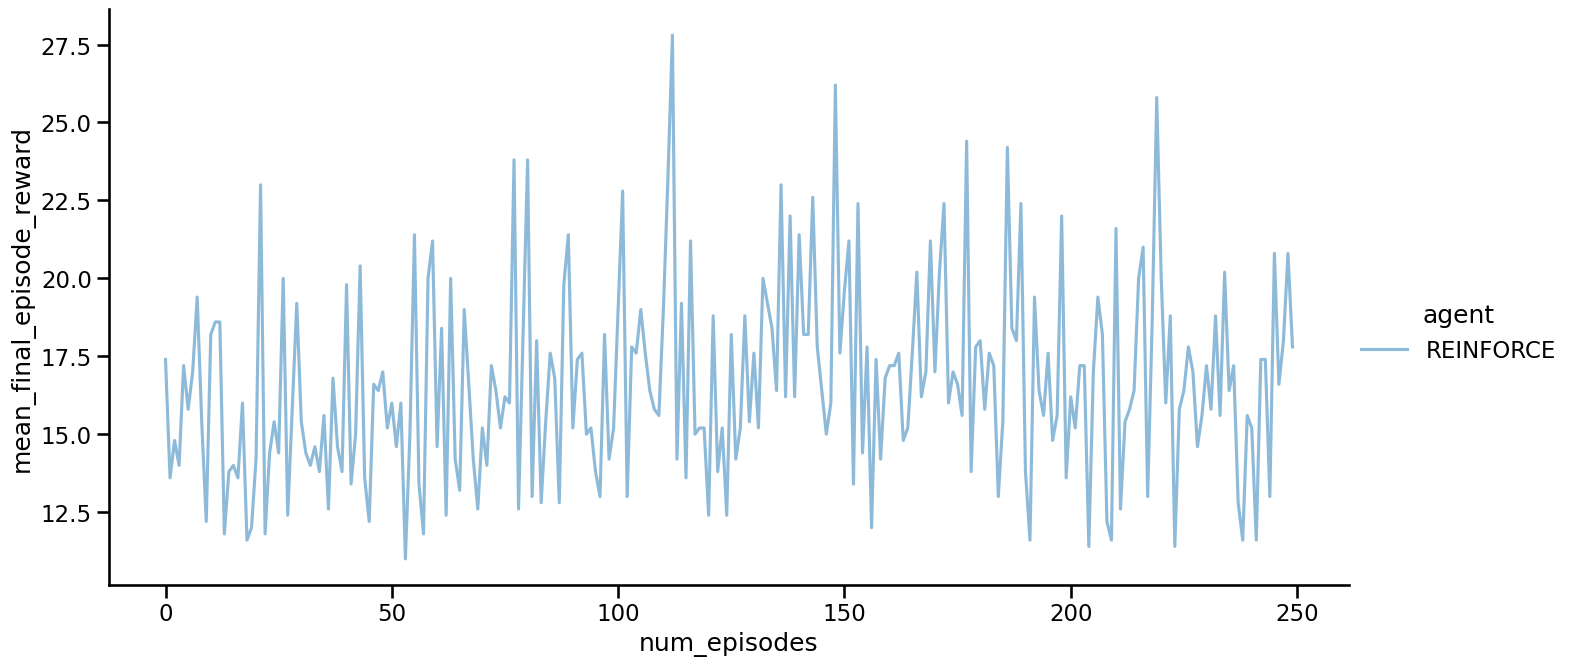

In [133]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=reinforce_trains_result_df, height=7, aspect=2, alpha=0.5)
plt.savefig("lab6_reinforce_cartpole_trains_result.png")

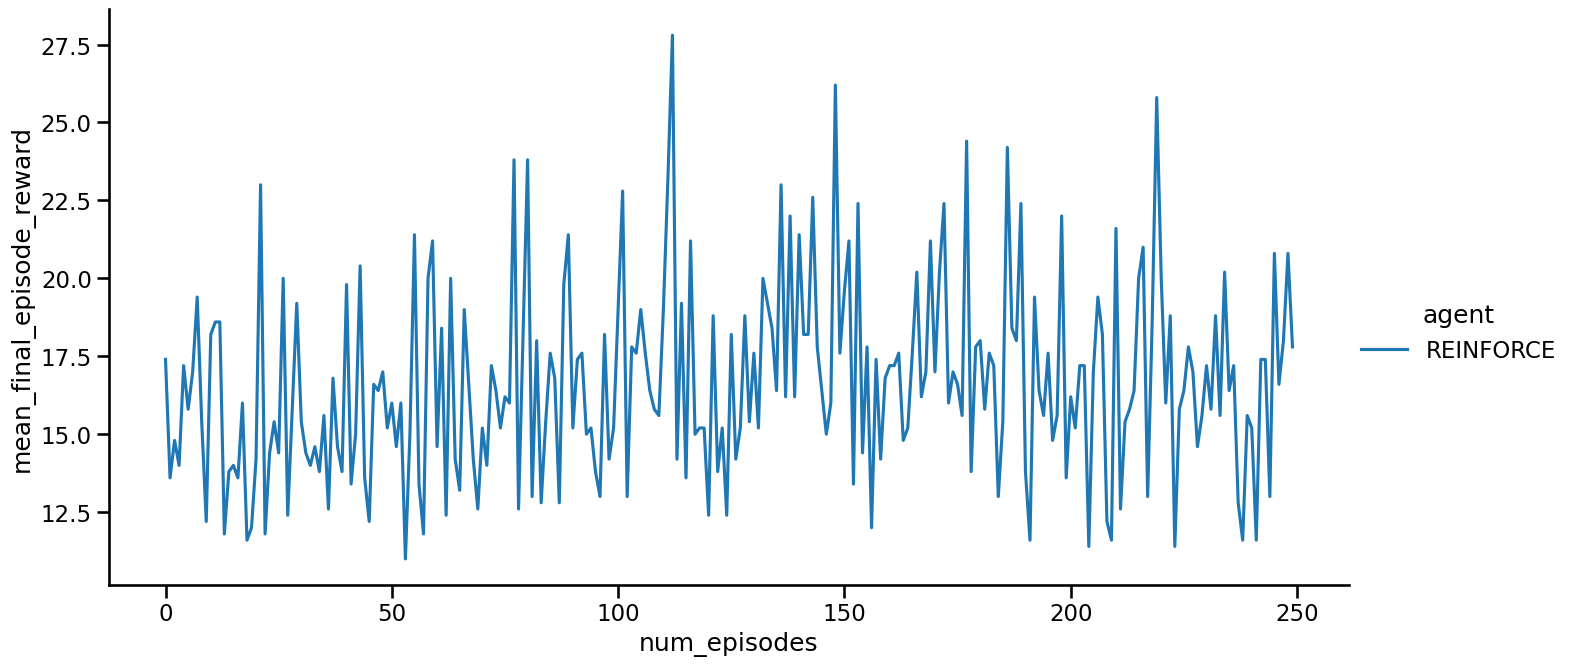

In [134]:
g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", hue="agent", kind="line", data=reinforce_trains_result_df, height=7, aspect=2)
plt.savefig("lab6_reinforce_cartpole_trains_result_agg.png")

#### Test final policy

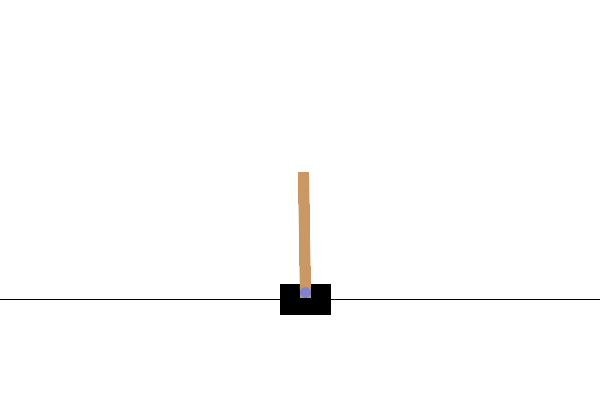

In [135]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
RenderWrapper.register(env, force_gif=True)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n.item()

episode_states, episode_actions, episode_rewards, episode_log_prob_actions = sample_one_episode(env, reinforce_policy_nn, 200, render=True)

env.close()
env.render_wrapper.make_gif("lab6_reinforce_tained")

**Task 5.9**: decrease the learning rate value (e.g. 0.001), increase the number of episodes per training and retrain the agent. What do you observe ?

  0%|          | 0/500 [00:00<?, ?it/s]

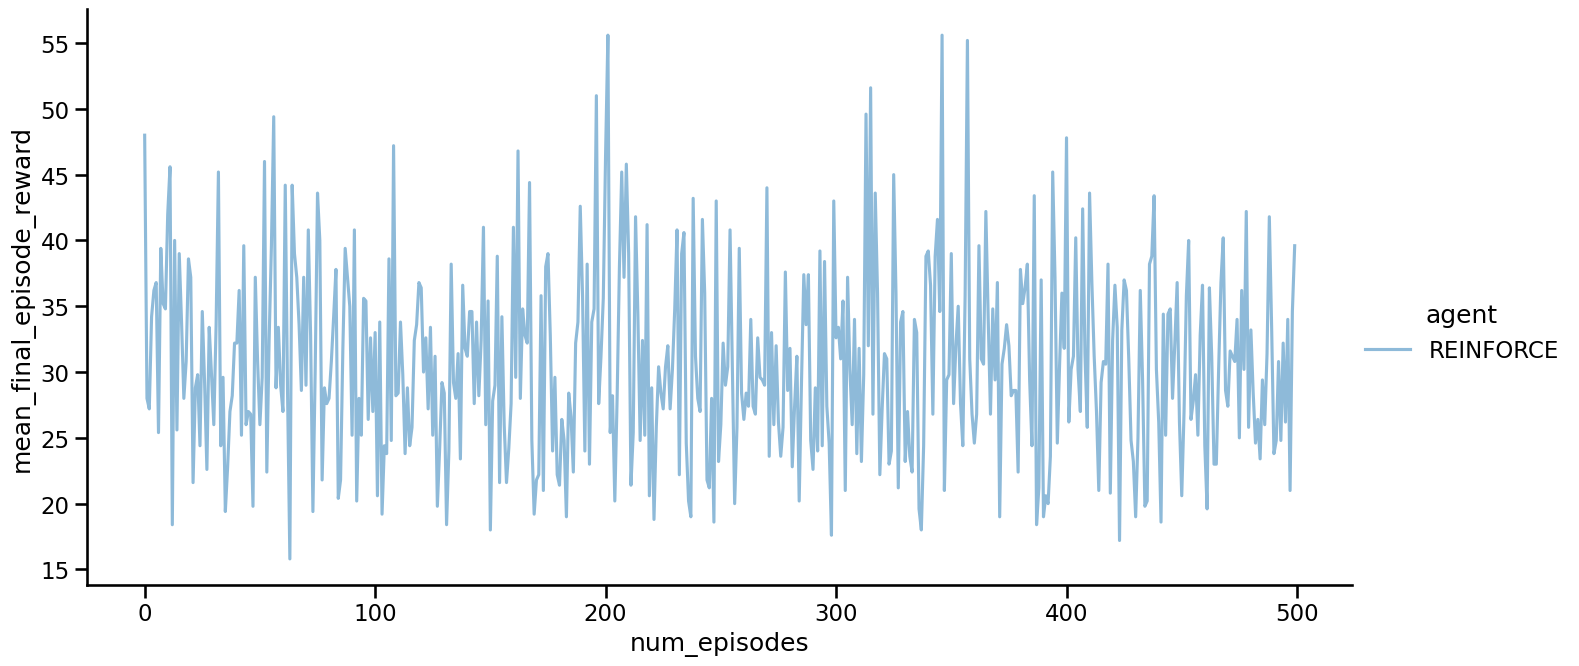

In [136]:
env = gym.make('CartPole-v1')

# NUMBER_OF_TRAININGS = 3
reinforce_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Train the agent
    reinforce_policy_nn, episode_reward_list = train_reinforce_discrete(env=env,
                                                                        num_train_episodes=500,
                                                                        num_test_per_episode=5,
                                                                        max_episode_duration=200,
                                                                        learning_rate=0.001)

    reinforce_trains_result_list[0].extend(range(len(episode_reward_list)))
    reinforce_trains_result_list[1].extend(episode_reward_list)
    reinforce_trains_result_list[2].extend([train_index for _ in episode_reward_list])

reinforce_trains_result_df = pd.DataFrame(np.array(reinforce_trains_result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
reinforce_trains_result_df["agent"] = "REINFORCE"

# Save the action-value estimation function of the last train

torch.save(reinforce_policy_nn, "reinforce_policy_network.pth")

env.close()

g = sns.relplot(x="num_episodes", y="mean_final_episode_reward", kind="line", hue="agent", estimator=None, units="training_index", data=reinforce_trains_result_df, height=7, aspect=2, alpha=0.5)
plt.savefig("lab6_reinforce_cartpole_trains_result.png")

In [137]:
#I do observe that the max mean reward when using 0.001 as a learning rate is getting better.

#### Score

In [138]:
score_ex5 = reinforce_trains_result_df[["num_episodes", "mean_final_episode_reward"]].groupby("num_episodes").mean().max()
score_ex5

mean_final_episode_reward    55.6
dtype: float64

In [139]:
end_time = time.time()
print(f"Elapsed time: {end_time - start_time} seconds")

Elapsed time: 266.06198835372925 seconds
